In [ ]:
!unzip /content/user-filtered.csv.zip

Archive:  /content/user-filtered.csv.zip
  inflating: user-filtered.csv       


In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552451 sha256=8cb879b884f76abe49f5e437f9a3eb692a478ce8bafa5a866b3d167176889c94
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
import pandas as pd
import numpy as np
from annoy import AnnoyIndex
from scipy.sparse import csr_matrix

# Load anime details
anime_details = pd.read_csv('/content/anime-filtered.csv', usecols=['anime_id', 'Name', 'sypnopsis'])

In [ ]:
# Load user and anime IDs from CSV to reconstruct mappings
user_ratings = pd.read_csv('/content/user-filtered.csv', usecols=['user_id', 'anime_id'])

In [ ]:
# Re-create mappings from actual user and anime IDs
user_ids = user_ratings['user_id'].unique()
anime_ids = anime_details['anime_id'].unique()

In [ ]:
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
anime_id_to_index = {anime_id: index for index, anime_id in enumerate(anime_ids)}
index_to_anime_id = {index: anime_id for anime_id, index in anime_id_to_index.items()}

In [ ]:
# Load the sparse matrix data
user_item_data = np.load('/content/anime_user_matrix_sparse.npz')
user_item_matrix_sparse = csr_matrix((user_item_data['data'], user_item_data['indices'], user_item_data['indptr']),
                                     shape=user_item_data['shape'])

In [ ]:
# Load item embeddings and normalized embeddings
item_embeddings_normalized = pd.read_csv('/content/item_embeddings_normalized.csv').values

# Load the Annoy index
n_factors = 100
annoy_index = AnnoyIndex(n_factors, 'angular')
annoy_index.load('anime_annoy_index.ann')

True

In [ ]:
def recommend_anime_annoy_user(user_id, user_item_matrix, anime_details, annoy_index,
                               user_id_to_index, anime_id_to_index, index_to_anime_id,
                               user_embeddings_normalized, n_neighbors=5, n_recommendations=5):
    if user_id not in user_id_to_index:
        print("User ID not found in the dataset.")
        return

    # Get the index of the user
    user_idx = user_id_to_index[user_id]

    # Find similar users
    similar_users_indices = annoy_index.get_nns_by_item(user_idx, n_neighbors + 1)[1:]

    # Aggregate ratings from similar users, limiting to filtered anime indices
    similar_users_ratings = user_item_matrix[similar_users_indices]

    # Get the anime indices corresponding to the filtered anime IDs
    filtered_anime_indices = [anime_id_to_index[anime_id] for anime_id in index_to_anime_id.values()]
    filtered_ratings = similar_users_ratings[:, filtered_anime_indices]

    # Compute the mean ratings for each filtered anime
    mean_ratings = filtered_ratings.mean(axis=0).A1  # Convert to 1D array

    # Convert to a Series with filtered anime indices
    mean_ratings_series = pd.Series(mean_ratings, index=index_to_anime_id.keys())

    # Get anime_ids already rated by the user, filtered to only those in index_to_anime_id
    user_ratings = user_item_matrix[user_idx]
    user_rated_anime = user_ratings.nonzero()[1]
    user_rated_anime_ids = [
        index_to_anime_id[idx] for idx in user_rated_anime
        if idx in index_to_anime_id
    ]

    # Exclude anime already rated by the user
    recommendations = mean_ratings_series.drop(user_rated_anime_ids, errors='ignore')


    # Create a list of tuples (anime_name, confidence_score)
    recommendation_tuples = []
    for anime_id, score in zip(recommendations.index, recommendations.values):
        # Check if the anime_id exists in anime_details
        anime_name_series = anime_details[anime_details['anime_id'] == anime_id]['Name']
        if not anime_name_series.empty:
            anime_name = anime_name_series.values[0]
            recommendation_tuples.append((anime_name, score))

    return recommendation_tuples


def recommend_anime_annoy_anime(anime_title, anime_details, annoy_index,
                                 anime_id_to_index, index_to_anime_id,
                                 item_embeddings_normalized):
    # Find the anime_id based on the title
    anime_subset = anime_details[anime_details['Name'].str.lower() == anime_title.lower()]
    if anime_subset.empty:
        print("Anime title not found in the dataset.")
        return []
    anime_id = anime_subset['anime_id'].values[0]
    anime_idx = anime_id_to_index.get(anime_id, None)

    if anime_idx is None:
        print("Anime index not found.")
        return []

    # Find similar anime indices using Annoy
    similar_anime_indices, distances = annoy_index.get_nns_by_item(
        anime_idx,
        len(anime_details) + 1,  # +1 to exclude the anime itself
        include_distances=True
    )

    # Exclude the anime itself
    similar_anime_indices = similar_anime_indices[1:]
    distances = distances[1:]

    # Convert angular distances back to cosine similarity
    # Cosine similarity = 1 - (distance^2 / 2)
    cosine_similarities = 1 - (np.array(distances)**2) / 2

    # Map indices back to anime_ids
    similar_anime_ids = [index_to_anime_id.get(idx) for idx in similar_anime_indices
                         if idx in index_to_anime_id]

    # Prepare the list of recommendations with confidence scores and anime names
    recommendation_tuples = [
        (anime_details[anime_details['anime_id'] == anime_id]['Name'].values[0], score)
        for anime_id, score in zip(similar_anime_ids, cosine_similarities)
    ]
    # Sort the recommendations by confidence score in descending order
    recommendation_tuples.sort(key=lambda x: x[1], reverse=True)

    return recommendation_tuples  # Returns list of tuples (anime_name, confidence_score)

In [ ]:
favorite_anime_title = "Naruto"  # Replace with the desired anime title
recommended_anime = recommend_anime_annoy_anime(
        anime_title=favorite_anime_title,
        anime_details=anime_details,
        annoy_index=annoy_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        item_embeddings_normalized=item_embeddings_normalized)

In [ ]:
similar_anime_indices, distances = annoy_index.get_nns_by_item(
        1729,
        len(anime_details) + 1,  # +1 to exclude the anime itself
        include_distances=True)
print(max(distances))

1.3526948690414429


In [ ]:
user_id_input = 23
recommendations = recommend_anime_annoy_user(
        user_id=user_id_input,
        user_item_matrix=user_item_matrix_sparse,
        anime_details=anime_details,
        annoy_index=annoy_index,
        user_id_to_index=user_id_to_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        user_embeddings_normalized=item_embeddings_normalized,
        n_neighbors=10,
        n_recommendations=10
)
print(f"Top 5 Recommendations for User ID {user_id_input}:\n")
print(recommendations)

Top 5 Recommendations for User ID 23:

[('Cowboy Bebop: Tengoku no Tobira', 0.5), ('Trigun', 0.7), ('Witch Hunter Robin', 0.0), ('Bouken Ou Beet', 0.0), ('Eyeshield 21', 0.0), ('Hachimitsu to Clover', 0.0), ('Hungry Heart: Wild Striker', 0.0), ('Initial D Fourth Stage', 0.0), ('Monster', 6.5), ('Naruto', 0.0), ('One Piece', 0.0), ('Tennis no Ouji-sama', 0.0), ('Ring ni Kakero 1', 0.0), ('School Rumble', 0.0), ('Sunabouzu', 0.0), ('Texhnolyze', 0.0), ('Trinity Blood', 0.0), ('Yakitate!! Japan', 0.0), ('Neon Genesis Evangelion', 0.0), ('Neon Genesis Evangelion: Death & Rebirth', 0.0), ('Neon Genesis Evangelion: The End of Evangelion', 0.0), ('Kenpuu Denki Berserk', 0.0), ('Koukaku Kidoutai', 0.0), ('Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen', 0.7), ('Rurouni Kenshin: Meiji Kenkaku Romantan', 0.7), ('Rurouni Kenshin: Meiji Kenkaku Romantan - Ishinshishi e no Chinkonka', 0.0), ('Akira', 0.0), ('.hack//Sign', 0.0), ('Aa! Megami-sama!', 0.0), ('Aa! Megami-sama! (TV)', 0.0), ('Ten

In [ ]:
print(len(recommendations))

6853


In [ ]:
content_df=pd.read_csv('/content/keywords_title (1).csv')
content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13228 entries, 0 to 13227
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13228 non-null  int64 
 1   Title       13228 non-null  object
 2   Keywords    13228 non-null  object
dtypes: int64(1), object(2)
memory usage: 310.2+ KB


In [ ]:
from nltk.corpus import stopwords
import re
import ast
import nltk
from nltk.stem import PorterStemmer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
contraction_mapping = {"ain't": "is not", "its": "it is","aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
stop_words = set(stopwords.words('english'))
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
content_df.drop(['Unnamed: 0'],axis=1,inplace=True)
content_df['Keywords'] = content_df['Keywords'].apply(ast.literal_eval)

In [ ]:
for i in range(13228):
    words=content_df['Keywords'][i]
    for j in range(len(words)):
        words[j]=list(words[j])
    content_df['Keywords'][i]=words
print(content_df['Keywords'][10])

[['naruto', 0.6194], ['konohagakure', 0.4758], ['kyuubi', 0.4646], ['ninja', 0.4147], ['hokage', 0.3895], ['demon', 0.3415], ['uzumaki', 0.3361], ['rampage', 0.3155], ['deadly', 0.2892], ['village', 0.2886], ['havoc', 0.2874], ['sacrificed', 0.2837], ['attacked', 0.2537], ['foes', 0.251], ['fox', 0.2509], ['fourth', 0.2478], ['oments', 0.2434], ['monstrous', 0.2417], ['life', 0.2346], ['leader', 0.2302], ['birth', 0.2268], ['nine', 0.2209], ['order', 0.211], ['hidden', 0.2103], ['living', 0.2074]]


In [ ]:
ks = PorterStemmer()
for i in range(13228):
    words=content_df['Keywords'][i]
    for j in range(len(words)):
        words[j][0]=ks.stem(words[j][0])
    content_df['Keywords'][i]=words
print(content_df['Keywords'][10])

[['naruto', 0.6194], ['konohagakur', 0.4758], ['kyuubi', 0.4646], ['ninja', 0.4147], ['hokag', 0.3895], ['demon', 0.3415], ['uzumaki', 0.3361], ['rampag', 0.3155], ['deadli', 0.2892], ['villag', 0.2886], ['havoc', 0.2874], ['sacrif', 0.2837], ['attack', 0.2537], ['foe', 0.251], ['fox', 0.2509], ['fourth', 0.2478], ['oment', 0.2434], ['monstrou', 0.2417], ['life', 0.2346], ['leader', 0.2302], ['birth', 0.2268], ['nine', 0.2209], ['order', 0.211], ['hidden', 0.2103], ['live', 0.2074]]


In [ ]:
sample_text="ghost helps father save his daughter"
sample_text=text_cleaner(sample_text)
results={}
for i in sample_text.split():
    for j in range(13228):
        words=content_df['Keywords'][j]
        for k in range(len(words)):
            if(words[k][0]==i):
                if words[k][0] in results.keys() or words[k][0] in results.values():
                    results[content_df['Title'][j]]+=words[k][1]
                else:
                    results[content_df['Title'][j]]=words[k][1]

In [ ]:
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
sorted_results=list(sorted_results.items())
for i in range(20):
    print(sorted_results[i])

('Ryuuichi Manga Gekijou Onbu Obake', 0.607)
('Gakkou no Kaidan', 0.5426)
('Teizokurei Daydream', 0.5407)
('Obake no Dokurou', 0.5359)
('GS Mikami', 0.5315)
('Hiiro no Kakera', 0.5284)
('Musaigen no Phantom World', 0.5272)
('Gegege no Kitarou: Kitarou no Yuurei Densha', 0.5248)
('Gakkou no Yuurei', 0.5123)
('Gegege no Kitarou (1968)', 0.5037)
('Gegege no Kitarou (1971)', 0.5037)
('Muhyo to Rouji no Mahouritsu Soudan Jimusho', 0.4985)
('Inagawa Junji no Sugoku Kowai Hanashi', 0.4981)
('Gegege no Kitarou (1985)', 0.4929)
('Chiisana Obake: Acchi, Kocchi, Socchi', 0.4891)
('Sinbi Apateu: Ghost Ball Bimil', 0.4888)
('Katte ni Kaizou', 0.4873)
('Da Wang Bu Gaoxing', 0.4827)
('Obake no... Holly', 0.4797)
('Kyoukai no Rinne (TV)', 0.476)


In [ ]:
user_id=int(input("Enter the user id"))
fav_anime=input("Enter the user's favourite anime title")
description=input("Enter the query")

Enter the user id14
Enter the user's favourite anime titleSinbi Apateu: Ghost Ball Bimil
Enter the querykid learns to play basketball


In [ ]:
results={}
for i in description.split():
    for j in range(13228):
        words=content_df['Keywords'][j]
        for k in range(len(words)):
            if(words[k][0]==i):
                if words[k][0] in results.keys() or words[k][0] in results.values():
                    results[content_df['Title'][j]]+=words[k][1]
                else:
                    results[content_df['Title'][j]]=words[k][1]

In [ ]:
recommendations = recommend_anime_annoy_user(
        user_id=user_id,
        user_item_matrix=user_item_matrix_sparse,
        anime_details=anime_details,
        annoy_index=annoy_index,
        user_id_to_index=user_id_to_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        user_embeddings_normalized=item_embeddings_normalized,
        n_neighbors=10,
        n_recommendations=10
)

In [ ]:
recommended_anime = recommend_anime_annoy_anime(
        anime_title=fav_anime,
        anime_details=anime_details,
        annoy_index=annoy_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        item_embeddings_normalized=item_embeddings_normalized)

In [ ]:
recommendation_dict=dict(recommendations)
recommended_anime_dict=dict(recommended_anime)

In [ ]:
for title,score in recommendation_dict.items():
  recommendation_dict[title]=score*0.015

In [ ]:
for title,score in recommended_anime_dict.items():
  recommended_anime_dict[title]=score*0.1

In [ ]:
print(sorted(results.items(), key=lambda item: item[1], reverse=True))

[('Hatara Kids Mai Ham Gumi', 0.444), ('Chiisana Kyojin Microman', 0.4411), ('Golden Batman', 0.4081), ('Onegai! Samia Don', 0.4072), ('Kunimatsu-sama no Otoridai', 0.4009), ('Karaoke Senshi Mike-tarou', 0.4004), ('Play Ball 2nd', 0.3971), ('.hack//Intermezzo', 0.3951), ('Super Titans 15', 0.3881), ('Araburu Kisetsu no Otome-domo yo.', 0.3854), ('Animagear', 0.3838), ('Ishikeri', 0.3739), ('Chao Shen Youxi', 0.3687), ('Mama wa Poyopoyo Saurus ga Osuki', 0.3676), ('Gon Movie: Gon, the Little Fox', 0.3655), ('Digimon Frontier', 0.3621), ('Zuori Qing Kong', 0.3599), ('Zuori Qing Kong Pilot', 0.3599), ('Kaizoku Ouji', 0.357), ('Dan Doh!!', 0.3566), ('Akuei to Gacchinpo', 0.355), ('.hack//Liminality', 0.3544), ('Narutaru: Mukuro Naru Hoshi Tama Taru Ko', 0.3535), ('Slam Dunk: Hoero Basketman-damashii! Hanamichi to Rukawa no Atsuki Natsu', 0.3514), ('Rebirth', 0.3511), ('Chirorin Mura Monogatari', 0.348), ("Darwin's Game", 0.3471), ('Chikasugi Idol Akae-chan', 0.3464), ('Candy Candy: Haru no

In [ ]:
final_results={}
for title,score in results.items():
  if title in final_results.keys():
    final_results[title]+=score
  else:
    final_results[title]=score
for title,score in recommendation_dict.items():
  if title in final_results.keys():
    final_results[title]+=score
  else:
    final_results[title]=score
for title,score in recommended_anime_dict.items():
  if title in final_results.keys():
    final_results[title]+=score
  else:
    final_results[title]=score

In [ ]:
for i in range(20):
  print(sorted(final_results.items(), key=lambda item: item[1], reverse=True)[i])

('Chiisana Kyojin Microman', 0.5136488988875685)
('Hatara Kids Mai Ham Gumi', 0.4923988716896164)
('Araburu Kisetsu no Otome-domo yo.', 0.483636441487681)
('Golden Batman', 0.4814045624640731)
('Kunimatsu-sama no Otoridai', 0.47379757045521675)
('Ishikeri', 0.47267727623366107)
('Super Titans 15', 0.46794679270508066)
('Chao Shen Youxi', 0.4652258182053731)
('Gon Movie: Gon, the Little Fox', 0.46055777387800245)
('Zuori Qing Kong Pilot', 0.4589018425614009)
('Zuori Qing Kong', 0.4584720517413852)
('Akuei to Gacchinpo', 0.45140180537782004)
('Rebirth', 0.44915336026731134)
('Kaizoku Ouji', 0.44683889403490146)
('Chikasugi Idol Akae-chan', 0.4453385367422257)
("Darwin's Game", 0.4444565337263785)
('Onegai! Samia Don', 0.4442935952264972)
('Play Ball 2nd', 0.43698989917428327)
('Karaoke Senshi Mike-tarou', 0.4338164922953725)
('The Night Game: Neko no Sakusen', 0.4330213791754101)


In [ ]:
sample_user_ids=user_ids[:100]
sample_anime_ids=anime_ids[:100]

In [ ]:
relevance_scores_user=[]
for i in sample_user_ids:
  x=recommend_anime_annoy_user(
        user_id=i,
        user_item_matrix=user_item_matrix_sparse,
        anime_details=anime_details,
        annoy_index=annoy_index,
        user_id_to_index=user_id_to_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        user_embeddings_normalized=item_embeddings_normalized,
        n_neighbors=10,
        n_recommendations=10)
  temp=[]
  for j in x:
    temp.append(j[1])
  relevance_scores_user.append(temp)

In [ ]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.asfarray(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    return np.sum((2 ** relevance_scores - 1) / np.log2(np.arange(1, relevance_scores.size + 1) + 1))

def ndcg_at_k(relevance_scores, k):
    dcg_max = dcg_at_k(sorted(relevance_scores, reverse=True), k)
    if dcg_max == 0:
        return 0.0
    return dcg_at_k(relevance_scores, k) / dcg_max

# Sample data: Relevance scores for movies recommended to different users
data = {
    'user_id': sample_user_ids,
    'relevance_scores': relevance_scores_user
}

df = pd.DataFrame(data)

# Set cutoff for NDCG
k = 100000


# Calculate NDCG for each user
df['NDCG'] = df['relevance_scores'].apply(lambda scores: ndcg_at_k(scores, k))

# Average NDCG across users
average_ndcg = df['NDCG'].mean()

print("NDCG Scores per User:")
print(df[['user_id', 'NDCG']])

print(f"\nOverall Average NDCG@{k}: {average_ndcg:.4f}")


NDCG Scores per User:
    user_id      NDCG
0         0  0.362813
1         1  0.562094
2         2  0.328156
3         3  0.391111
4         4  0.560253
..      ...       ...
95       99  0.596284
96      101  0.620682
97      102  0.577544
98      103  0.554905
99      104  0.621893

[100 rows x 2 columns]

Overall Average NDCG@100000: 0.3957


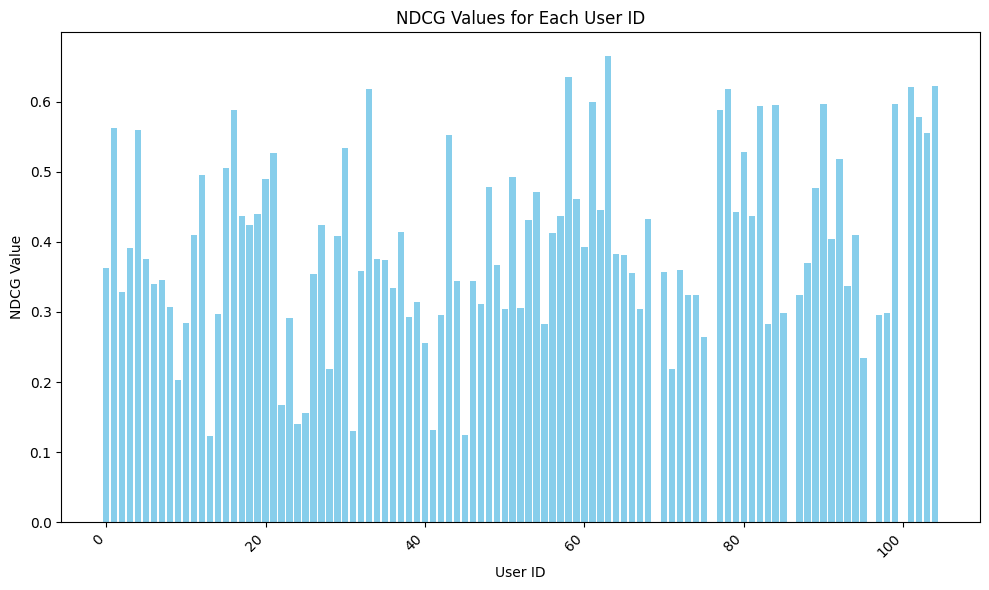

In [ ]:
import matplotlib.pyplot as plt
# Assuming you have a list of user IDs and their corresponding NDCG values
user_ids = df['user_id']  # Replace with your actual user IDs
ndcg_values = df['NDCG']   # Replace with your actual NDCG values

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(user_ids, ndcg_values, color='skyblue')

# Customize the plot
plt.xlabel("User ID")
plt.ylabel("NDCG Value")
plt.title("NDCG Values for Each User ID")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Show the plot
plt.show()

In [ ]:
titles=anime_details['Name'].unique()
titles=titles[:100]
relevance_scores=[]
for i in titles:
  x=recommend_anime_annoy_anime(
        anime_title=i,
        anime_details=anime_details,
        annoy_index=annoy_index,
        anime_id_to_index=anime_id_to_index,
        index_to_anime_id=index_to_anime_id,
        item_embeddings_normalized=item_embeddings_normalized)
  temp=[]
  for j in x:
    temp.append(j[1])
  relevance_scores.append(temp)

In [ ]:
data = {
    'title': titles,
    'relevance_scores': relevance_scores
}

df = pd.DataFrame(data)

# Set cutoff for NDCG
k = 100000


# Calculate NDCG for each user
df['NDCG'] = df['relevance_scores'].apply(lambda scores: ndcg_at_k(scores, k))

# Average NDCG across users
average_ndcg = df['NDCG'].mean()

print("NDCG Scores per User:")
print(df[['title', 'NDCG']])

print(f"\nOverall Average NDCG@{k}: {average_ndcg:.4f}")

NDCG Scores per User:
                                 title  NDCG
0                         Cowboy Bebop   1.0
1      Cowboy Bebop: Tengoku no Tobira   1.0
2                               Trigun   1.0
3                   Witch Hunter Robin   1.0
4                       Bouken Ou Beet   1.0
..                                 ...   ...
95            El Hazard: The Wanderers   1.0
96    El Hazard: The Magnificent World   1.0
97  El Hazard 2: The Magnificent World   1.0
98                      Final Approach   1.0
99                       Fruits Basket   1.0

[100 rows x 2 columns]

Overall Average NDCG@100000: 1.0000


In [ ]:
relevance_scores=list(results.values())
ndcg=ndcg_at_k(relevance_scores,k)
print("Obtained NDCG = ",ndcg)


Obtained NDCG =  0.9285247332464729
